<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/ThirdStockEnivornment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Necessary Packages for Training the Trading Agent

To train the Trading Agent the package [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html) was used. As stated in the docs: 
> Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It is the next major version of Stable Baselines. And steems from the paper [Stable-Baselines3: Reliable Reinforcement Learning Implementations](https://jmlr.org/papers/volume22/20-1364/20-1364.pdf)
The algorithms in this package will make it easier for the research community and industry to replicate, refine, and identify new ideas, and will create good baselines to build projects on top of. We expect these tools will be used as a base around which new ideas can be added, and as a tool for comparing a new approach against existing ones. We also hope that the simplicity of these tools will allow beginners to experiment with a more advanced toolset, without being buried in implementation details.

---
## Proximal Policy Optimization(PPO):

Because in this environment the Agent will be executing continous actions, the Proximal Policy Optimization(PPO) algorithm was chosen. As detailed by the authors [PPO](https://arxiv.org/pdf/1707.06347.pdf)


> We propose a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a “surrogate” objective function using stochastic gradient ascent. Whereas standard policy gradient methods perform one gradient update per data sample, we propose a novel objective function that enables multiple epochs of minibatch updates. The new methods, which we call proximal policy optimization (PPO), have some of the benefits of trust region policy optimization (TRPO), but they are much simpler to implement, more general, and have better sample complexity (empirically).


PPO uses the following novel objective function:

$L^{CLIP}(θ)=\hat{E}_t[min(r_{t}(θ)\hat{A}_t,clip(r_{t}(θ), 1-ϵ, 1+ϵ)\hat{A}_t]$

*  $\theta$ is the policy parameter
*  $\hat{E}_t$ denotes the empirical expectation over timesteps
*  $r_{t}$ is the ratio of the probability under the new and old policies, respectively
*  $\hat{A}_t$ is the estimated advantage at time t
*  $\epsilon$ is the clipping hyperparameter, usually 0.1 or 0.2


As detailed by the authors [openAI](https://openai.com/blog/openai-baselines-ppo/#ppo)


> This objective implements a way to do a Trust Region update which is compatible with Stochastic Gradient Descent, and simplifies the algorithm by removing the KL penalty and need to make adaptive updates. In tests, this algorithm has displayed the best performance on continuous control tasks and almost matches ACER’s performance on Atari, despite being far simpler to implement


  









In [ ]:
# ignore warning messages because they are annoying lol
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install stable-baselines3[extra] # reinforcement learning library
!pip install optuna # hyperparameter library
!pip install --upgrade importlib-metadata==4.13.0 # for backwards compatibility issue

In [ ]:
import random
import gym 
from gym import spaces
from gym.utils import seeding
import pandas as pd
import numpy as np
import json
import datetime as dt
import optuna
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
from stable_baselines3 import PPO
from stable_baselines3.common.utils import constant_fn
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import VecCheckNan, check_env
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, StopTrainingOnRewardThreshold
from empyrical import sortino_ratio, calmar_ratio, omega_ratio
import sqlite3
from sqlite3 import Error
import torch as th
import torch.nn as nn
import collections
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
import os
import csv
from csv import DictWriter

# Third Stock Trading Environment


  This third stock trading environment is based on Adam King's articles as found here:[Creating Bitcoin trading bots don’t lose money](https://medium.com/towards-data-science/creating-bitcoin-trading-bots-that-dont-lose-money-2e7165fb0b29) and here:[Optimizing deep learning trading bots using state-of-the-art techniques](https://towardsdatascience.com/using-reinforcement-learning-to-trade-bitcoin-for-massive-profit-b69d0e8f583b)
Furthermore, the random offset in the reset method and the if/and control flow is based on Maxim Lapan's implementation as found in chapter eight of his book [Deep Reinforcement Learning Hands-On: Apply modern RL methods to practical problems of chatbots, robotics, discrete optimization, web automation, and more, 2nd Edition](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-optimization/dp/1838826998).

Similar to the first and second stock trading environment, the agent is trading in the [SPY ETF](https://www.etf.com/SPY?L=1) environment and the [Yandax](https://en.wikipedia.org/wiki/Yandex) environment; and is trading in a continous action space(i.e.[0-2] for buying, selling, or holding and [0-1] for % sold/bought where 1 is equivalent to 100%)  and  the observation space is from [-inf,inf])(*note: however, in the second stock trading environment this space ranged from [-1,1]*).Also unlike the second stock trading environment, an additional observation was added to the agent's observations space of an account history/ledger of the agent's past networth from trading (*note: this window is set by the variable LOOKBACK_WINDOW_SIZE and its default is 10 days*)and a commision parameter used in the cost and sales calculation (*note: default is 0.1%*). 

Additionally, three different ways of calculating the agent's reward were added, namely: 
* BalenceReward: a simple reward scheme that Adam King created that multiplies the agent's balance by a delay modifier that is based on the current offset (i.e.step) of the agent in the environment see [Creating Bitcoin trading bots don’t lose money](https://medium.com/towards-data-science/creating-bitcoin-trading-bots-that-dont-lose-money-2e7165fb0b29) for more details
* StandkeCurrentValueReward: a simple reward scheme that I created that is the difference of the previous trading day's networth and the current trading day's networth multiplied by the agent's balance and Adam King's delay modifier that is based on the current step in the environment 
* StandkeCurrentBasketReward (aka None): a simple reward scheme based off Maxim Lapan's reward scheme that multiplies the current price value of the asset by the quantity held


In [ ]:
# stock environment parameters
MAX_ACCOUNT_BALANCE = 2147483647 
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 4294967295
LOOKBACK_WINDOW_SIZE = 10 # trading window, default is 10 frames 
MAX_STEPS = 1e6 # max steps agent can take in environment 
INITIAL_ACCOUNT_BALANCE = 10000 # starting balance and networth

# default percentage of stock price trading agent pays broker when 
# buying/selling, default is 0.1% (i.e. very reasonable)
DA_COMMISION = 0.1

In [ ]:
# Stock/ETF Trading Enviornment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, title, reward_func='BalenceReward', random=True):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.random_ofs_on_reset = random
        self.reward_func = reward_func
        self.bars_count = LOOKBACK_WINDOW_SIZE
        self.commission = DA_COMMISION
        self.title = title
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([2, 1]), dtype=np.float32)

        # Prices contains the OHCL values for the last five prices the state 
        # space is 12 dim i.e. 6 x 2 = 12
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)
        
        # setting random seed
        self.seed()

        # creating header for text output
        header = "Time, Networth, Balence, SharesHeld"
        with open(self.title, 'a') as f:
          f.write(header + "\n")
          f.close

    def reset(self):
      # random offset portion 
      bars = self.bars_count
      if self.random_ofs_on_reset:
        offset = self.np_random.choice(self.data.high.shape[0]-bars*10)+bars
      else:
        offset = bars
      self._reset(offset)
      return self._next_observation()

    def _reset(self, offset):
      self.trades = []
      self.balance = INITIAL_ACCOUNT_BALANCE
      self.netWorth = INITIAL_ACCOUNT_BALANCE
      self.max_net_worth = INITIAL_ACCOUNT_BALANCE
      self.shares_held  = 0
      self._offset = offset
      # setting account history portion
      self.account_history = np.repeat([[INITIAL_ACCOUNT_BALANCE]], LOOKBACK_WINDOW_SIZE, axis=1)

    # shape of observation space is 2D
    @property
    def shape(self):
      return (6, self.bars_count)

    def _next_observation(self):
      res = np.zeros(shape=(6, self.bars_count), dtype=np.float32)
      ofs = self.bars_count-1
      res[0] = self.data.volume[self._offset-ofs:self._offset+1]
      res[1] = self.data.high[self._offset-ofs:self._offset+1]
      res[2] = self.data.low[self._offset-ofs:self._offset+1]
      res[3] = self.data.open[self._offset-ofs:self._offset+1]
      res[4] = self.account_history[0][-self.bars_count:]
      res[5] = self.data.close[self._offset-ofs:self._offset+1]
      res = np.float32(res)
      return res
       
    def _take_action(self, action):
      reward = 0
      current_price = self._cur_close()
      action_type = int(action[0])
      amount = action[1]
      
      shares_bought = 0
      shares_sold = 0
      additional_cost = 0
      sales = 0


      if action_type < 1 and self.balance:
        # Buy amount % of balance in shares
        total_possible = self.balance / (current_price * (1+self.commission))
        shares_bought = total_possible * amount
        additional_cost = shares_bought * current_price * (1+self.commission)
        self.balance -= int(additional_cost)
        self.shares_held += int(shares_bought)
        # trading history
        if shares_bought > 0:
          self.trades.append({'step': self._offset, 'shares': shares_bought, 
                              'total': additional_cost, 'type': "buy"})
      elif action_type < 2 and self.shares_held:
        # Sell amount % of shares held
        shares_sold = self.shares_held * amount  
        sales = shares_sold * current_price * (1 - self.commission)
        self.balance += int(sales)
        self.shares_held -= int(shares_sold)
        # trading history
        if shares_sold > 0:
          self.trades.append({'step': self._offset, 'shares': -shares_sold, 
                              'total': shares_sold * current_price, 'type': "sell"}) 
      else:
        # Hold and ride the bull or bear
        pass    
      
      self.netWorth = self.balance + self.shares_held * current_price
      
      if self.netWorth > self.max_net_worth:
        self.max_net_worth = self.netWorth

      # updating account history
      self.account_history = np.append(self.account_history, [[self.netWorth]], axis=1)
      
      # reward Calculations
      returns = self.account_history[0][-self.bars_count:]
      # calcualtion for ratio based rewards
      r = np.diff(returns)
      # BalenceReward 
      if self.reward_func == 'BalenceReward':
        delay_modifier = (self._offset / MAX_STEPS)
        reward = self.balance * delay_modifier
      # StandkeCurrentValueReward
      elif self.reward_func == 'StandkeCurrentValueReward':
        prev_net = returns[-2]
        current_net = returns[-1]
        ratio = current_net-prev_net
        delay_modifier = (self._offset / MAX_STEPS)
        reward = ratio * self.balance * delay_modifier
      # StandkeCurrentBasketReward (i.e. none)
      else:
        reward = self.shares_held * current_price 
      return reward if abs(reward) != np.inf and not np.isnan(reward) else 0

      
    def _cur_close(self):
      """
      Calculate real close price for the current bar
      """
      return self.data.real_close[self._offset]

    def step(self, action):
      # Execute one time step within the environment
      reward = self._take_action(action)
      self._offset += 1
      if self._offset >= self.data.close.shape[0]-1 or int(self.netWorth)<1 or int(self.netWorth)>=MAX_ACCOUNT_BALANCE:
        done=True
      else:
        done=False
      obs = self._next_observation()
      info = {"Net Worth":self.netWorth, "reward": reward, 'Balance': self.balance}
      return obs, reward, done, info

    def _render_to_file(self):
      with open(self.title, 'a') as f:
        f.write(f'{self.data.date[self._offset]},{self.netWorth},{self.balance},{self.shares_held}\n')
        f.close()
 
    def render(self, mode='file', title="Agent's Trading Screen", **kwargs):
      # Render the environment to the screen
      if mode == 'file':
        self._render_to_file()


    def seed(self, seed=None):
      self.np_random, seed1 = seeding.np_random(seed)
      seed2 = seeding.hash_seed(seed1+1) % 2**33
      return [seed1, seed2]


# Data Preprocessing Steps

1.   First the data is made [stationary](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/) to remove any trends or seasonality associated with the time series data
2.   Then the price data is converted into releative prices to model the relative change rather than absolute change in prices (i.e. generally used in [technical analysis](https://www.investopedia.com/terms/t/technicalanalysis.asp))
3. Lastly the data is normalized using sklearn's [min-max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) as to fit within the environment's observation space of [0-1]


# SPY ETF Data 

* 1 frame i.e. a time window of 1 is one day of trading as detailed by the candlestick graph, showing 10 days of trading 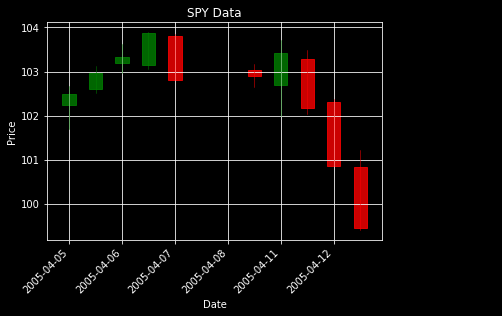

* data spans from beginning of 2005 to mid/late 2022
* training data consists of 3201 samples
* testing data consists of 1210 samples

In [ ]:
# create a differenced series as done in step 1 (see link for more info)
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = np.log(dataset[i]) - np.log(dataset[i - interval])
		diff.append(value)
	return diff
 
# training data
df = pd.read_csv('/content/drive/MyDrive/Datasets/StockMarketData/archive/Data/ETFs/spy.us.txt') # load csv data from directory
df = df.sort_values('Date')
data=df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# making OHLC data stationary  
diff_o = np.array(difference(data['Open'], 1))
diff_h = np.array(difference(data['High'], 1))
diff_l = np.array(difference(data['Low'], 1))
diff_c = np.array(difference(data['Close'], 1))
# volumne data
vol = data['Volume'].values
# year data of year-month-day form
dt = data['Date'].array
o =  diff_o
rc = diff_c
rh = diff_h
rl = diff_l

Train_Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume', 'real_open',  'real_close', 'real_high', 'real_low', 'real_vol'])
train = Train_Data(date=dt,high=rh, low=rl, close=rc, open=o, volume=vol, real_open=data['Open'].values, real_close=data['Close'].values, real_high=data['High'].values, real_low=data['Low'].values, real_vol=data['Volume'].values)

In [ ]:
# Testing data
test = pd.read_csv('/content/drive/MyDrive/Datasets/StockMarketData/test.csv') # load csv data from directory
t_df = test.sort_values('Date')
data_two=t_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# making OHLC data stationary  
diff_o = np.array(difference(data_two['Open'], 1))
diff_h = np.array(difference(data_two['High'], 1))
diff_l = np.array(difference(data_two['Low'], 1))
diff_c = np.array(difference(data_two['Close'], 1))
# volumne data
vol = data_two['Volume'].values
# year data of year-month-day form
dt = data_two['Date'].array
o =  diff_o
rc = diff_c
rh = diff_h
rl = diff_l

Test_Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume', 'real_open', 'real_close', 'real_high', 'real_low', 'real_vol'])
test = Test_Data(date=dt,high=rh, low=rl, close=rc, open=o, volume=vol, real_open=data['Open'].values, real_close=data_two['Close'].values, real_high=data_two['High'].values, real_low=data_two['Low'].values, real_vol=data['Volume'].values)

# Yandex Stock Data

* 1 frame i.e. a time window of 100 makes up one minute of trading as detailed by Max Lapan's candelstick
graph 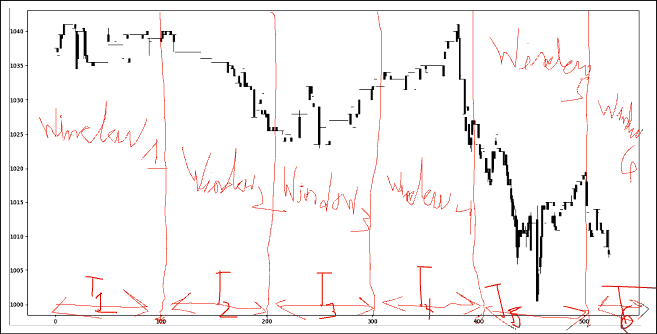

* data spans from beginning of 2015 to end of 2016
* training data consists of 196,581 samples
* testing data consists of 65,527 samples

In [ ]:
# !tar xvf /content/drive/MyDrive/Datasets/StockMarketData/ch08-small-quotes/ch08-small-quotes.tgz

In [ ]:
# # loading data
# df_train = pd.read_csv('/content/YNDX_150101_151231.csv') 
# df_test = pd.read_csv('/content/YNDX_160101_161231.csv')
# combine = pd.concat([df_train, df_test], axis=0)
# X_train, X_test = train_test_split(combine, test_size=0.25, shuffle=False)

In [ ]:
# X_train=X_train[['<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
# X_test=X_test[['<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]

In [ ]:
# # making OHLC data stationary
# diff_o = np.array(X_train['<OPEN>'].diff().dropna())
# diff_h = np.array(X_train['<HIGH>'].diff().dropna())
# diff_l = np.array(X_train['<LOW>'].diff().dropna())
# diff_c = np.array(X_train['<CLOSE>'].diff().dropna())
# # volumne data
# vol = X_train['<VOL>'].values
# # Time in seconds
# dt = X_train['<TIME>'].array

# Train_Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume', 'real_open',  'real_close', 'real_high', 'real_low', 'real_vol'])
# train = Train_Data(date=dt,high=diff_h, low=diff_l, close=diff_c, open=diff_o, volume=vol, real_open=X_train['<OPEN>'].values, real_close=X_train['<CLOSE>'].values, real_high=X_train['<HIGH>'].values, real_low=X_train['<LOW>'].values, real_vol=X_train['<VOL>'].values)

In [ ]:
# # making OHLC data stationary
# diff_o = np.array(X_test['<OPEN>'].diff().dropna())
# diff_h = np.array(X_test['<HIGH>'].diff().dropna())
# diff_l = np.array(X_test['<LOW>'].diff().dropna())
# diff_c = np.array(X_test['<CLOSE>'].diff().dropna())
# # volumne data
# vol = X_test['<VOL>'].values
# # Time in seconds
# dt = X_test['<TIME>'].array

# test_Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume', 'real_open',  'real_close', 'real_high', 'real_low', 'real_vol'])
# test = test_Data(date=dt,high=diff_h, low=diff_l, close=diff_c, open=diff_o, volume=vol, real_open=X_test['<OPEN>'].values, real_close=X_test['<CLOSE>'].values, real_high=X_test['<HIGH>'].values, real_low=X_test['<LOW>'].values, real_vol=X_test['<VOL>'].values)

# Creating Seperate Policy/Value Network Class using a 1D CNN Feature extractor

Stable-baselines3's lists the following blog on PPO [37 implementation details of PPO](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/) which breaks down the different implementations of PPO. Furthermore, as the authors of [WHAT MATTERS FOR ON-POLICY DEEP ACTOR CRITIC METHODS? A LARGE-SCALE STUDY](https://openreview.net/pdf?id=nIAxjsniDzg) detail: 


> Separate value and policy networks (C47) appear to lead to better performance on our out of five environments (Fig. 15). To avoid analyzing the other choices based on bad models, we thus focus for the rest of this experiment only on agents with separate value and policy networks. Regarding network sizes, the optimal width of the policy MLP depends on the complexity of the environment (Fig. 18) and too low or too high values can cause significant drop in performance while for the value function there seems to be no downside in using wider networks (Fig. 21). Moreover, on some environments it is beneficial to make the value network wider than the policy one, e.g. on HalfCheetah the best results are achieved with 16 − 32 units per layer in the policy network and 256
in the value network. Two hidden layers appear to work well for policy (Fig. 22) and value networks (Fig. 20) in all tested environments. As for activation functions, we observe that tanh activations perform best and relu worst

> Interestingly, the initial policy appears to have a surprisingly high impact on the training performance.The key recipe is to initialize the policy at the beginning of training so that the action distribution is centered around 0<sup>10</sup> regardless of the observation and has a rather small standard deviation. This can be achieved by initializing the policy MLP with smaller weights in the last layer (C57, Fig. 24, this alone boosts the performance on Humanoid by 66%) so that the initial action distribution is almost
independent of the observation...Other choices appear to be less important: The scale of the last layer initialization matters much less for the value MLP (C58) than for the policy MLP (Fig. 19). Apart from the last layer scaling, the
network initialization scheme (C56) does not matter too much (Fig. 27)

> Recommendation. Initialize the last policy layer with 100× smaller weights. Use softplus to transform network output into action standard deviation and add a (negative) offset to its input to decrease the initial standard deviation of actions. Tune this offset if possible. Use tanh both as the activation function (if the networks are not too deep) and to transform the samples from the normal
distribution to the bounded action space. Use a wide value MLP (no layers shared with the policy) but tune the policy width (it might need to be narrower than the value MLP)

With these statements in mind, I decided to implement a seperate-network architecture for PPO for both the policy and value network as detailed below. 

## 1D CNN Feature Extractor

This is the architecture used for the Policy's feature extractor: 
```
self.cnn = nn.Sequential(
            nn.Conv1d(input, 32, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Flatten(),
```
This is the architecture used for the Value's feature extractor: 
```
self.cnn = nn.Sequential(
            nn.Conv1d(input,128,kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Flatten(),
        )

```
## Policy Network
This is the architecture used for the Policy Network: 
```
  self.policy_net = nn.Sequential(
            layer_init(nn.Linear(feature_dim, 32)),
            nn.Tanh(),
            layer_init(nn.Linear(32, last_layer_dim_pi), std=0.01),
            nn.Tanh(),  
        )
```
## Value Network 
This is the architecture used for the Value Network:
```
self.value_net = nn.Sequential(
           layer_init(nn.Linear(256, 256)),
           nn.Tanh(),
           layer_init(nn.Linear(256, 128)),
           nn.Tanh(),
           layer_init(nn.Linear(128,32)),
           nn.Tanh(),
           layer_init(nn.Linear(32,last_layer_dim_vf)),
           nn.Tanh(),
           )
```



In [ ]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    th.nn.init.orthogonal_(layer.weight, std)
    th.nn.init.constant_(layer.bias, bias_const)
    return layer

class StandkePolicyExtractor(BaseFeaturesExtractor):
  def __init__(self, observation_space=gym.spaces.Box, features_dim=128):
        super(StandkePolicyExtractor, self).__init__(observation_space, features_dim)
        input = observation_space.shape[0]
        # Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input,16,kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]
  
  def forward(self, observations):
    return self.cnn(observations)


class StandkeValueExtractor(BaseFeaturesExtractor):
  def __init__(self, observation_space=gym.spaces.Box, features_dim=128):
        super(StandkeValueExtractor, self).__init__(observation_space, features_dim)
        input = observation_space.shape[0]
        # Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input,128,kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        
  def forward(self, observations):
    return self.cnn(observations)



class StandkeNetwork(nn.Module):
  def __init__(self,feature_dim=32, last_layer_dim_pi=2, last_layer_dim_vf=1):
        super(StandkeNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

         # Policy Network
        self.policy_net = nn.Sequential(
            layer_init(nn.Linear(feature_dim, 32)),
            nn.Tanh(),
            layer_init(nn.Linear(32, last_layer_dim_pi), std=0.01),
            nn.Tanh(),  
        )


         # Value Network
        self.value_net = nn.Sequential(
           layer_init(nn.Linear(256, 256)),
           nn.Tanh(),
           layer_init(nn.Linear(256, 128)),
           nn.Tanh(),
           layer_init(nn.Linear(128,32)),
           nn.Tanh(),
           layer_init(nn.Linear(32,last_layer_dim_vf)),
           nn.Tanh(),
           )

  def forward_actor(self, features: th.Tensor):
    return self.policy_net(features)

  def forward_critic(self, features: th.Tensor):
    return self.value_net(features)
  

class StandkePolicy(ActorCriticPolicy):
  def __init__(self, observation_space=gym.spaces.Box,action_space=gym.spaces.Box, lr_schedule=constant_fn(0.0003), activation_fn=nn.Tanh,*args,**kwargs):
    
        super(StandkePolicy, self).__init__(observation_space,action_space, lr_schedule, activation_fn,*args,**kwargs)
        # non-shared features extractors 
        self.policy_features_extractor = StandkePolicyExtractor(observation_space)
        self.value_features_extractor = StandkeValueExtractor(observation_space)
        delattr(self, "features_extractor")  # remove the shared features extractor
        # orthogonal initialization
        self.ortho_init = False

  def _build_mlp_extractor(self):
    self.mlp_extractor = StandkeNetwork()

  def extract_features(self, obs: th.Tensor):
    policy_features = self.policy_features_extractor(obs)
    value_features = self.value_features_extractor(obs)
    return policy_features, value_features
  
  def forward(self, obs: th.Tensor, deterministic=False): 
    policy_features, value_features = self.extract_features(obs)
    mu_pi = self.mlp_extractor.forward_actor(policy_features)
    latent_vf = self.mlp_extractor.forward_critic(value_features)
    # Evaluate the values for the given observations
    distribution = self._get_action_dist_from_latent(mu_pi)
    actions = distribution.get_actions(deterministic=deterministic)
    log_prob = distribution.log_prob(actions)
    vf = latent_vf
    return actions, vf, log_prob

  def evaluate_actions(self, obs: th.Tensor, actions: th.Tensor): 
    policy_features, value_features = self.extract_features(obs)
    mu_pi = self.mlp_extractor.forward_actor(policy_features)
    latent_vf = self.mlp_extractor.forward_critic(value_features)
    distribution = self._get_action_dist_from_latent(mu_pi)
    actions = distribution.get_actions(deterministic=False)
    log_prob = distribution.log_prob(actions)
    vf = latent_vf
    return vf, log_prob, distribution.entropy()

  def get_distribution(self, obs: th.Tensor):
    policy_features, _ = self.extract_features(obs)
    latent_pi = self.mlp_extractor.forward_actor(policy_features)
    return self._get_action_dist_from_latent(latent_pi)

  def predict_values(self, obs: th.Tensor):
    _, value_features = self.extract_features(obs)
    latent_vf = self.mlp_extractor.forward_critic(value_features)
    return latent_vf

# Tensorboard Callback to graph Mean Networth, Mean Episodic Reward, & Mean Episodic Balance on Test Data

In [ ]:
def evaluate_policy(model,env,n_eval_episodes=2,deterministic=False):
    episode_rewards, networths, episode_balances = [], [], []
    for i in range(n_eval_episodes):
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        episode_balance = 0
        networth = 0
        obs = env.reset()
        while not done:
            action, state = model.predict(obs, state=state, deterministic=deterministic)
            new_obs, reward, done, _info = env.step(action)
            obs = new_obs
            episode_reward += reward
            episode_balance += _info[0]['Balance']
            # networth += _info[0]['Net Worth']
        episode_rewards.append(episode_reward)
        episode_balances.append(episode_balance)
        networths.append(_info[0]['Net Worth'])
    mean_reward = np.mean(episode_rewards)
    mean_networth = np.mean(networths)
    mean_balance = np.mean(episode_balances)
    return mean_reward, mean_networth, mean_balance


class TensorboardCallback(BaseCallback):
    def __init__(self, env, eval,  verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.eval= eval
        self.env = env

    def _on_step(self):
      if (self.num_timesteps % self.eval == 0):
        m, net, bal = evaluate_policy(self.model, self.env)
        self.logger.record('Validation Mean Networth', net)
        self.logger.record('Mean Episode Balance', bal)
      return True

# HyperParmater Tuning to Maxamize Balance

Following the optimization sceme as outlined by Adam King in his article [Optimizing deep learning trading bots using state-of-the-art techniques](https://towardsdatascience.com/using-reinforcement-learning-to-trade-bitcoin-for-massive-profit-b69d0e8f583b) Bayesian Optimization was done using [Optuna](https://optuna.org/)


 



In [ ]:
# # objective is maxamize reward

# def objective_fn(trial):
#     env_params = optimize_envs(trial)
#     agent_params = optimize_ppo(trial)
    
#     train_env = DummyVecEnv([lambda: StockTradingEnv(train, random=False)])
#     validation_env = DummyVecEnv([lambda: StockTradingEnv(test, random=False)])
#     model = PPO(StandkePolicy, train_env, **agent_params)
#     model.learn(len(train_env.get_attr('data')[0].date))
#     done, track  = False, []
#     obs = validation_env.reset()
#     for i in range(len(validation_env.get_attr('data')[0].date)):
#         action, _ = model.predict(obs)
#         obs, reward, done, _info = validation_env.step(action)
#         track.append(_info[0]['Balance'])
#         if done:
#           return np.mean(track)

# # def optimize_ppo(trial):
# #     return {
# #         'gamma': trial.suggest_float('gamma1', 0.1, 0.9, log=True),
# #         'clip_range': trial.suggest_float('clip_range1', 0.1, 0.5, log=True),
# #         'clip_range_vf': trial.suggest_float('clip_range_vf2', 0.1, 0.5, log=True),
# #         'ent_coef':trial.suggest_float('ent_coef3', 0.1, 0.9, log=True), 
# #         'vf_coef':trial.suggest_float('vf_coef4', 0.1, 0.9, log=True),
# #         'target_kl': trial.suggest_float('target_kl5', 0.01, 0.05, log=True),
# #     }

# def optimize_ppo(trial):
#   return {'learning_rate': trial.suggest_float('lr',2e-8,2e-4, log=True)}

# def optimize_envs(trial):
#     # return {'reward_func': trial.suggest_categorical('reward_func1', ['BalenceReward',  'StandkeCurrentValueReward'])}
#     return {'reward_func': 'StandkeCurrentValueReward'}


# study = optuna.create_study(study_name='StockEnvPPO_Parms', direction="maximize", storage="sqlite:///PPOhyper.db", load_if_exists=True)
# study.optimize(objective_fn, n_trials=2000, show_progress_bar=True)

In [ ]:
# # loading the hyperparmeters for training
# study = optuna.load_study(study_name='StockEnvPPO_Parms', storage='sqlite:///PPOhyper.db')
# params = study.best_trial.params

# # other hyperparameters after 3000 trials given gamma and sortinoRewardRatio 
# model_params = {
#     'clip_range': params['clip_range1'],
#     'ent_coef': params['ent_coef3'],
#     'clip_range_vf': params['clip_range_vf2'],
#     'vf_coef': params['vf_coef4']
# }

# # gamma parameter after 2853 trials under the sortinoRewardRatio 
# model_params['gamma'] = 0.20423582857078215

In [ ]:
model_params = {}

# Training and Validation Portion

In [ ]:
FEQ = MAX_STEPS/100

# the number of concurrent environments for training  
ENV = 1

# different model reward schemes
MODEL = "BalenceReward"
# MODEL = "StandkeCurrentValueReward"
# MODEL = None 


env_params = {'reward_func': MODEL}

In [ ]:
# create evaluation env that takes in test data that saves best model 
eval_env = DummyVecEnv([lambda: StockTradingEnv(test, f'{MODEL}.txt', **env_params, random=False)])
eval_callback = EvalCallback(eval_env, best_model_save_path=f'/content/drive/MyDrive/RLmodels/bestPPO/{MODEL}',
                             log_path='/content/drive/MyDrive/RLmodels/logs/', eval_freq=FEQ,
                             deterministic=False, render=False, n_eval_episodes=2)

# create training envs that takes in training data for training
envs =  DummyVecEnv([lambda: StockTradingEnv(train, f'{MODEL}.txt', **env_params, random=True) for _ in range(0,ENV)])

'''training model using the Seperate Standke Policy/Value network'''
# optional additional keyword parameters to pass to model 
policy_kwargs = dict()

# creating callback list for tracking purposes 
callback = CallbackList([TensorboardCallback(eval_env, FEQ), eval_callback])

model = PPO(StandkePolicy, envs, **model_params, verbose=1, tensorboard_log=f"/content/PPO_SPY_tensorboard/{MODEL}", policy_kwargs=policy_kwargs)

# check to make sure no erros in the env, such as observation space errors or nans
check_env(StockTradingEnv(train, f'{MODEL}.txt'))
VecCheckNan(envs, raise_exception=True, check_inf=True)


# General explanation of log output 

As detailed by araffin in his commit [Add explanation of logger output](https://github.com/DLR-RM/stable-baselines3/pull/803/files), for a given log block such as

```
-----------------------------------------
  | eval/                   |             |
  |    mean_ep_length       | 200         |
  |    mean_reward          | -157        |
  | rollout/                |             |
  |    ep_len_mean          | 200         |
  |    ep_rew_mean          | -227        |
  | time/                   |             |
  |    fps                  | 972         |
  |    iterations           | 19          |
  |    time_elapsed         | 80          |
  |    total_timesteps      | 77824       |
  | train/                  |             |
  |    approx_kl            | 0.037781604 |
  |    clip_fraction        | 0.243       |
  |    clip_range           | 0.2         |
  |    entropy_loss         | -1.06       |
  |    explained_variance   | 0.999       |
  |    learning_rate        | 0.001       |
  |    loss                 | 0.245       |
  |    n_updates            | 180         |
  |    policy_gradient_loss | -0.00398    |
  |    std                  | 0.205       |
  |    value_loss           | 0.226       |
  -----------------------------------------
```
``eval/`` 
- ``mean_ep_length``: Mean episode length
- ``mean_reward``: Mean episodic reward (during evaluation)
``rollout/``
- ``ep_len_mean``: Mean episode length (averaged over 100 episodes)
- ``ep_rew_mean``: Mean episodic training reward (averaged over 100 episodes)
``time/``
- ``episodes``: Total number of episodes
- ``fps``: Number of frames per seconds (includes time taken by gradient update)
- ``iterations``: Number of iterations (data collection + policy update for A2C/PPO)
- ``time_elapsed``: Time in seconds since the beginning of training
- ``total_timesteps``: Total number of timesteps (steps in the environments)
``train/``
- ``clip_fraction``: mean fraction of surrogate loss that was clipped (above clip_range threshold) for PPO.
- ``clip_range``: Current value of the clipping factor for the surrogate loss of PPO
- ``learning_rate``: Current learning rate value
- ``n_updates``: Number of gradient updates applied so far
- ``policy_gradient_loss``: Current value of the policy gradient loss (its value does not have much meaning)
- ``std``: Current standard deviation of the noise when using generalized State-Dependent Exploration (gSDE) (which by default is not used)

# Important Training Metrics
- ``approx_kl``: approximate mean KL divergence between old and new policy (for PPO), it is an estimation of how much change happened in the update (i.e. information gain or loss)
  * **Want this value to SMOOTHLY decrease during training and be as close as possible to 0**
- ``explained_variance``: Fraction of the return variance explained by the value function.
  * **Should be SMOOTHLY increasing, and technically want values closer to 1 (but statistic interpertation is debatable because even with 0 the model does have predictive power, so the correct interpertaion of this statistic should be: *explained variation measures the proportion to which a mathematical model ACCOUNTS FOR THE VARIATION,not predictive power* [Explained Variation](https://en.wikipedia.org/wiki/Explained_variation)"**
- ``entropy_loss``: Mean value of the entropy loss (negative of the average policy entropy). 
  * **Should be MOVING**
- ``loss``: called total loss is the the overall loss function
  * **Should be SMOOTHLY decreasing, and technically, want to minimize this during training(though as discussed this isn't always possible due to randomness)**
- ``value_loss``: error that value function is incurring 
  * **Should be SMOOTHLY decreasing, and technically,want to minimize this during training(though as discussed this isn't always possible due to randomness) **






In [ ]:
model.learn(total_timesteps=MAX_STEPS, callback=callback)

# Prediction and CSV Printout of Agent's Trading Behaviour on Test Data


## Best Model Statistics-SpyData-StandkeCurrentValueReward

## Best Model Statistics-YandexData-StandkeCurrentValueReward

## Best Model Statistics-SpyData-BalenceReward

## Best Model Statistics-YandexData-BalenceReward





In [ ]:
# Model-Random Offset
# model = PPO.load(f"/content/drive/MyDrive/RLmodels/bestPPO/{MODEL}/best_model_random_offset.zip")
# # Model-No Random Offset
model = PPO.load(f"/content/drive/MyDrive/RLmodels/bestPPO/{MODEL}/best_model.zip")
env = StockTradingEnv(test, f'{MODEL}.txt', **env_params, random=False)
obs = env.reset()
for i in range(len(test.date)):
  action, _states = model.predict(obs, deterministic=False)
  obs, rewards, done, info = env.step(action)
  env.render()
  if done:
    break

In [ ]:
df = pd.read_csv('/content/BalenceReward.txt')

In [ ]:
df.head()

In [ ]:
args = {'xlabel':'Steps', 'ylabel':'Account'}
plot = df.plot(**args)
fig = plot.get_figure()
fig.show()

# TensorBoard Analysis

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/PPO_SPY_tensorboard/ 

# SPY Trading Results

# Yandex Trading Results